In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import get_MOI, zero_mean, get_Damped_Pendulum_Invariance, get_Damped_SHM_Invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_damped_SHM_data, get_damped_pendulum_data, get_grid_of_points, evaluate_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'


In [3]:
mean = zero_mean(2)
time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 170
n_train = 1
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

test_starting_position = np.random.uniform(-max_x, max_x)
test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position)
print(train_starting_velocity)

print(test_starting_position)
print(test_starting_velocity)

for gamma in [0.1]:
    print("current damping: %s" %gamma)
    data = get_damped_pendulum_data(gamma, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
    test_data = get_damped_pendulum_data(gamma, time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])
    mean_function = zero_mean(2)
    for jitter in [1e-5]:
        moi = get_GPR_model(get_MOI(), mean_function, data, 100)
        print("%s, "%round(moi.log_marginal_likelihood().numpy()))
        evaluate_moi = evaluate_model(moi, test_data, time_step)
        print(evaluate_moi[:2])
        for invar_density in [40]:#np.arange(10, 40, 10):
                try:
                    kernel = get_Damped_Pendulum_Invariance(3, invar_density, jitter)#switch
                    m = get_GPR_model(kernel, mean, data, 100)
                    print(round(m.log_marginal_likelihood().numpy()))
                    evaluate_invariance = evaluate_model(m, test_data, time_step)
                    print(m.kernel.epsilon.numpy())
                    print(evaluate_invariance[:2])

                except tf.errors.InvalidArgumentError:
                    print("jitter too small")
                    break

[154.76041533]
[29.56941192]
-40.71998650968462
-25.527386831108814
current damping: 0.1
71, 
(0.30878486637524205, 0.06670642258132982)
76
0.0870321994804564
(0.021005327931076265, 0.0078281297815763)


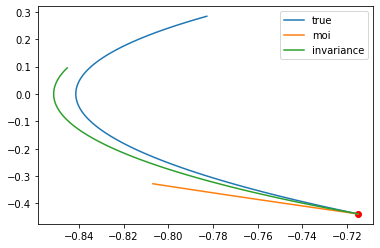

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="true")
plt.plot(evaluate_moi[2][:,0],evaluate_moi[2][:,1], label='moi')
plt.plot(evaluate_invariance[2][:,0],evaluate_invariance[2][:,1], label="invariance")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.legend()

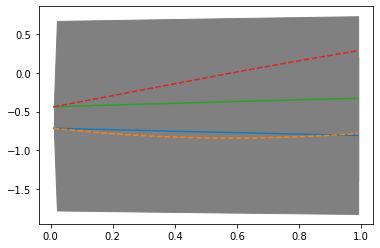

In [5]:

t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
plt.plot(t,evaluate_moi[2][:,0])
plt.fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_moi[2][:,1])
plt.fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')

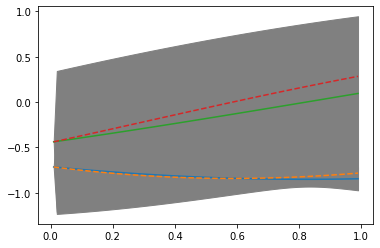

In [6]:

plt.plot(t,evaluate_invariance[2][:,0])
plt.fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_invariance[2][:,1])
plt.fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,1],'--')